In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
import random
from functions.displayer import (plot_cycle,
                                 plot_windowed_cycle,
                                 plot_loss,
                                 plot_reconstruction,
                                 plot_mae_per_cycle)
from functions.data_processor import DataProcessor
from models.encoder import LSTMEncoder
from models.decoder import LSTMDecoder
from models.autoencoder import Autoencoder
from functions.reconstruction import (reconstruct_cycles,
                                      calc_avg_mae_per_cycle)

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using LSTM-based autoencoders <br/><br/>- with overlapped windowing -</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

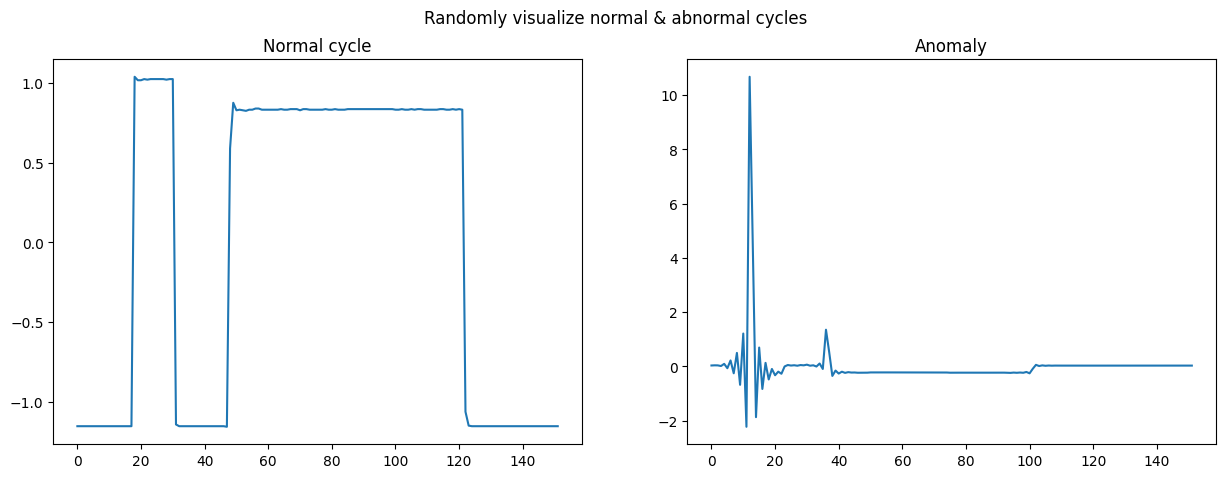

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


- Windowing: *Size = 64, gap = 8*

In [13]:
sub_length = 64
gap = 8

In [14]:
dp.windowing(sub_length, gap)

In [15]:
print('Train shape after windowing: ', dp.w_train.shape)

Train shape after windowing:  (10836, 64, 1)


- Visualize windowing overlapping impact

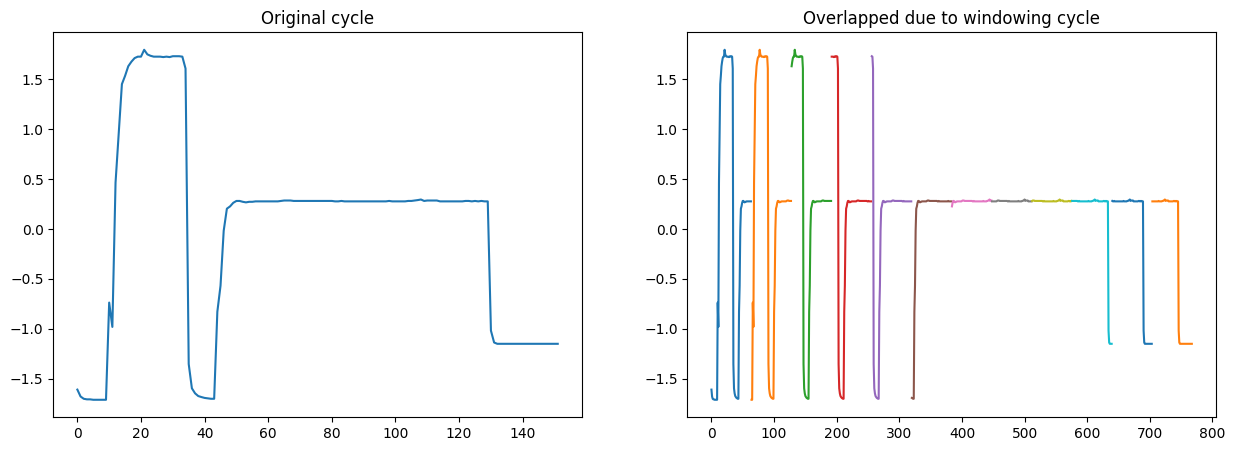

In [16]:
plot_windowed_cycle(dp.s_train, dp.w_train, gap=gap)

## II. Training an auto-encoder

#### 0. Dimensions definition

In [17]:
# Training set shape
shape = dp.w_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 4

#### 1. Create an LSTM encoder

In [18]:
encoder = LSTMEncoder(length_sequence, n_features, n_latent).model

#### 2. Create an LSTM decoder

In [19]:
decoder = LSTMDecoder(length_sequence, n_features, n_latent).model

#### 3. Create an auto-encoder

In [20]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [21]:
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1)]           0         
                                                                 
 Encoder-Model (Functional)  (None, 4)                 13060     
                                                                 
 Decoder-Model (Functional)  (None, 64, 1)             13157     
                                                                 
Total params: 26,217
Trainable params: 26,023
Non-trainable params: 194
_________________________________________________________________


#### 5. Fitting the model

- Training the model

In [22]:
history = ae.fit(x=dp.w_train,
                 y=dp.w_train,
                 batch_size=32,
                 epochs=15,
                 validation_data=(dp.w_test, dp.w_test))

Epoch 1/15
339/339 [==============================] - 89s 240ms/step - loss: 0.4094 - val_loss: 0.4274
Epoch 2/15
339/339 [==============================] - 85s 253ms/step - loss: 0.2461 - val_loss: 0.1817
Epoch 3/15
339/339 [==============================] - 82s 241ms/step - loss: 0.2037 - val_loss: 0.1828
Epoch 4/15
339/339 [==============================] - 81s 238ms/step - loss: 0.1831 - val_loss: 0.1476
Epoch 5/15
339/339 [==============================] - 66s 194ms/step - loss: 0.1696 - val_loss: 0.1364
Epoch 6/15
339/339 [==============================] - 65s 191ms/step - loss: 0.1610 - val_loss: 0.1319
Epoch 7/15
339/339 [==============================] - 74s 220ms/step - loss: 0.1532 - val_loss: 0.1233
Epoch 8/15
339/339 [==============================] - 83s 245ms/step - loss: 0.1484 - val_loss: 0.1247
Epoch 9/15
339/339 [==============================] - 82s 243ms/step - loss: 0.1448 - val_loss: 0.1124
Epoch 10/15
339/339 [==============================] - 66s 196ms/step - l

- Plotting loss functions

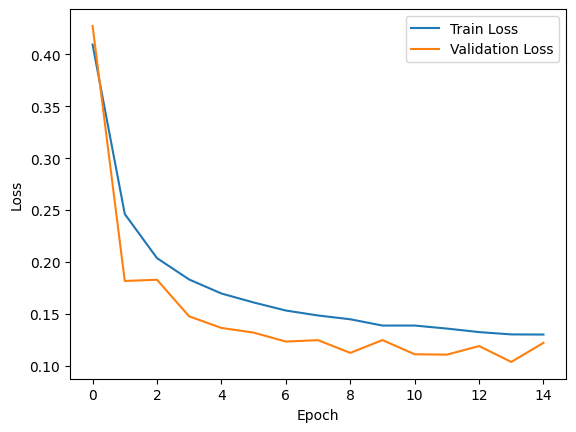

In [23]:
plot_loss(history)

#### 6. Test  windowed prediction

In [24]:
w_pred = ae.predict(dp.w_test)

2312/2312 [==============================] - 46s 19ms/step


#### 7. Visualize a windowed prediction

In [25]:
cycle = 5

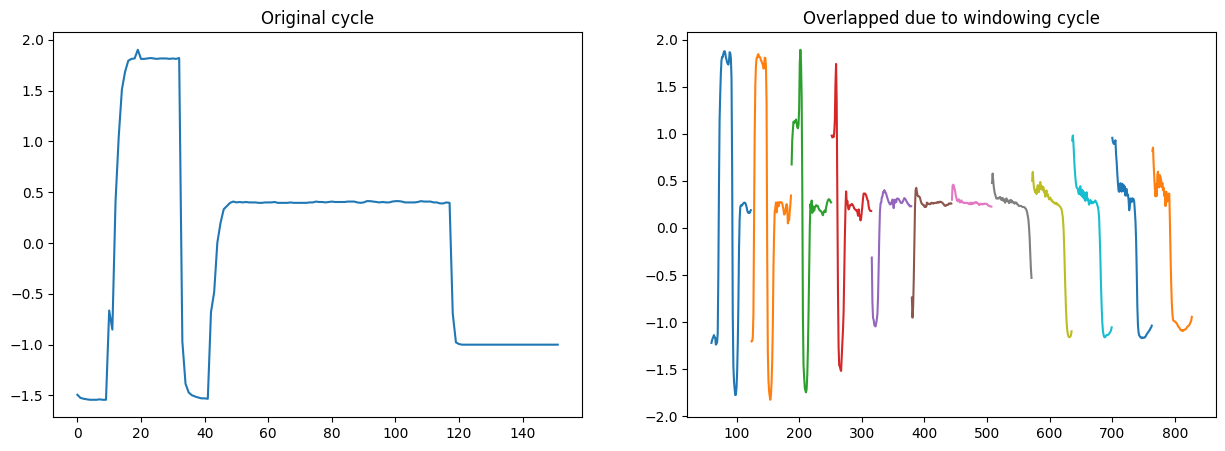

In [26]:
plot_windowed_cycle(dp.s_test, w_pred, cycle=cycle, gap=gap)

## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

- Calculate reconstructed cycles from windowed prediction by averaging over every overlap

In [27]:
r_pred = reconstruct_cycles(w_pred, length=152, sub_length=sub_length, gap=gap)

In [28]:
r_pred.shape

(6164, 152, 1)

- Plotting reconstructed cycle

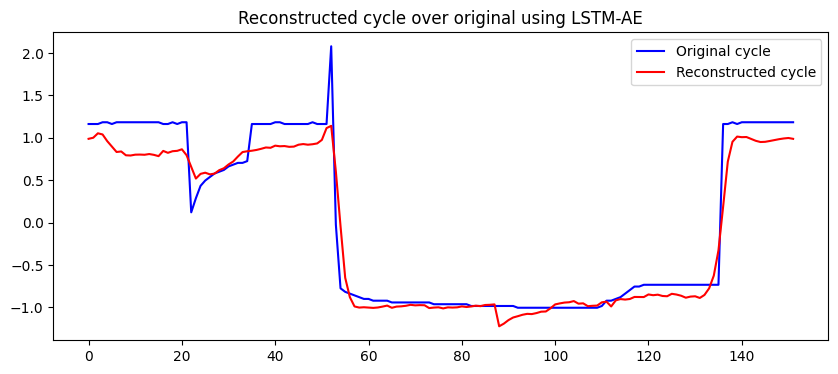

In [29]:
# Normal cycle
y_test_normal = y_test[y_test==1].index.tolist()
cycle = random.choice(y_test_normal)
plot_reconstruction(dp.s_test, r_pred, cycle)

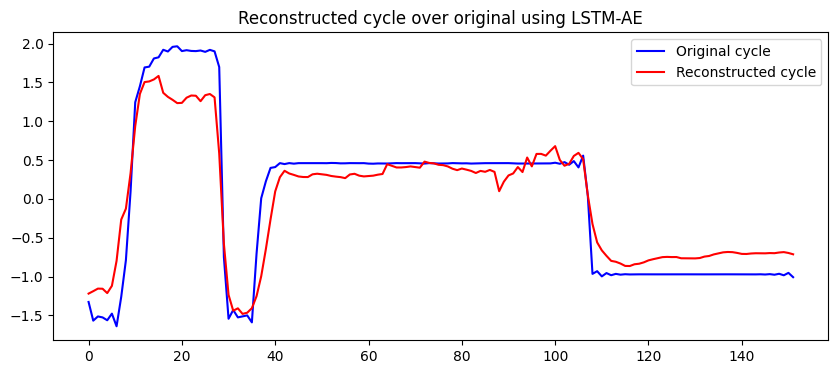

In [30]:
# Anomaly
y_test_anomaly = y_test[y_test==-1].index.tolist()
cycle = random.choice(y_test_anomaly)
plot_reconstruction(dp.s_test, r_pred, cycle)

#### 2. Average reconstruction error per cycle

- Calculate the average mean absolute error (MAE) per cycle between a set of original 3D sequences and their reconstructions.

In [31]:
mae_per_cycle = calc_avg_mae_per_cycle(dp.s_test, r_pred)

- Plotting the average reconstruction error per cycle

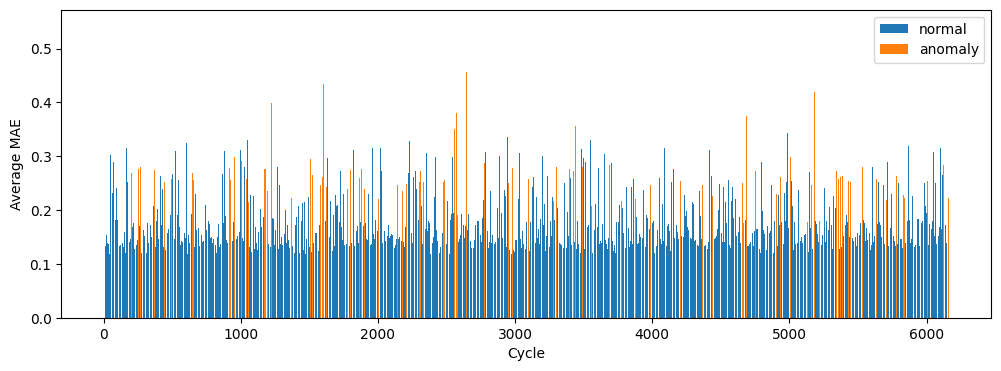

In [32]:
plot_mae_per_cycle(mae_per_cycle, y_test)

#### 3. Anomaly detection using a threshold on MAE per cycle

In [37]:
threshold = 0.2

In [38]:
y_pred = [1 if x<threshold else -1 for x in mae_per_cycle]

#### 4. Evaluation of anomaly detection using a threshold

In [39]:
accuracy = accuracy_score(y_test, y_pred)
confusion_m = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

In [40]:
print('Accuracy: %.2f' % accuracy, end='\n\n')
print('Confusion matrix: \n', confusion_m, end='\n\n')
print('Classification report: \n\n', cf_report)

Accuracy: 0.79

Confusion matrix: 
 [[ 633   32]
 [1278 4221]]

Classification report: 

               precision    recall  f1-score   support

          -1       0.33      0.95      0.49       665
           1       0.99      0.77      0.87      5499

    accuracy                           0.79      6164
   macro avg       0.66      0.86      0.68      6164
weighted avg       0.92      0.79      0.83      6164

